In [2]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [3]:
def get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo):
  dgs_amount = len(Be)
  lines = len(Be[0])
  # Cálculo dos pontos de operação
  io = []
  for k in range(lines):
    _io = 0.
    for j in range(dgs_amount):
      _io += Be[j][k] * vo[j]
    io += [(1. / R[k]) * _io]

  # Corrente do indutor de cada unidade
  it_o = []
  for i in range(dgs_amount):
    _it_o = 0.
    for k in range(lines):
      _it_o += Be[i][k] * io[k]
    it_o += [(Y[i] * vo[i]) + (Pl[i] / vo[i]) + _it_o]

  # Duty cycles de operação
  d_o = []
  for i in range(dgs_amount):
    d_o += [(vo[i] / vdc[i]) + (Rt[i] / vdc[i]) * it_o[i]]

  # Create the dictionary of parameters
  params = {'R': R, 'L': L, 'Rt': Rt,  'Lt': Lt, 'Ct': Ct, 'Y': Y, 'vdc': vdc,
            'Be': Be, 'Pl': Pl, 'v_o': vo, 'i_o': io, 'it_o': it_o, 'd_o': d_o}

  return params

In [4]:
def get_A(ρ, params):

  Y = np.diag(params['Y'])
  L = np.diag(params['L'])
  R = np.diag(params['R'])
  vo = np.diag(params['v_o'])
  Be = np.array(params['Be'])
  Ct = np.diag(params['Ct'])
  Lt = np.diag(params['Lt'])
  Rt = np.diag(params['Rt'])

  dgs_amount = len(Be)

  # Obtenção dos parâmetros \rho
  ρ1 = np.diag(ρ[0:dgs_amount])
  ρ2 = np.diag(ρ[dgs_amount:2*dgs_amount])

  Ct_inv = np.linalg.inv(Ct)
  Lt_inv = np.linalg.inv(Lt)
  L_inv = np.linalg.inv(L)
  vo_inv = np.linalg.inv(vo)

  A11 = - Ct_inv @ Y + Ct_inv @ vo_inv @ ρ1 @ ρ2
  A12 = Ct_inv
  A13 = - Ct_inv @ Be
  A21 = - Lt_inv
  A22 = - Lt_inv @ Rt
  A23 = np.zeros((A22.shape[0], A13.shape[1]))
  A31 = L_inv @ Be.T
  A32 = np.zeros((A31.shape[0], A22.shape[1]))
  A33 = - L_inv @ R

  return np.block([[A11, A12, A13],
                   [A21, A22, A23],
                   [A31, A32, A33]])


def get_B(ρ, params):
  Lt = np.diag(params['Lt'])
  Lt_inv = np.linalg.inv(Lt)
  Be = np.array(params['Be'])

  dgs_amount = len(Be)
  lines = len(Be[0])

  vdc = np.diag(params['vdc'])
  B11 = np.zeros((dgs_amount, dgs_amount))
  B21 = - Lt_inv @ vdc
  B31 = np.zeros((lines, dgs_amount))
  return np.block([[B11],
                   [B21],
                   [B31]])

In [5]:
simulation_step = 1e-4
simulation_time = 0.5
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))

# Conexões das linhas de potência (matriz de incidência: 6 DGs x 8 linhas)
Be = [
    [1.,  1.,  1.],
    [-1., 0.,  0],
    [0., -1.,  0.],
    [0.,  0.,  -1.]
]

dgs_amount = len(Be)
lines = len(Be[0])

# Resistências e indutâncias das 6 linhas de potência
R = [5] * lines  # Ω
L = [1e-3] * lines  # H

# Parâmetros locais das 8 unidades
Rt = [1e-3] * dgs_amount          # Resistência em série do indutor (Ω)
Lt = [1e-3] * dgs_amount          # Indutância do filtro (H)
Ct = [2.2e-3] * dgs_amount        # Capacitância do filtro (F)
Y = [1. / 50] * dgs_amount            # Admitância (S)
vdc = [600, 600, 600, 600]    # Tensão de entrada (V)
Pl = [25e3, 25e3, 25e3, 25e3]  # Potência da CPL (W)
vo = [320., 280., 280., 280.]     # Tensão de operação dos capacitores (V)

# Obtém parâmetros das 8 unidades
dg_params = get_dg_unit_params(R, L, Rt, Lt, Ct, Y, vdc, Be, Pl, vo)

# Cálculo de u_bar para cada DG
u_bar = [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])
         for i in range(dgs_amount)]

# Limites de perturbações de tensão
v_bounds = [[-50, 50]] * dgs_amount

ρ_bounds = np.array(
    [[1. / (vo[i] + v_bounds[i][1]), 1. / (vo[i] + v_bounds[i][0])]
     for i in range(dgs_amount)] +
    [[-20e3, 20e3]] * dgs_amount
)

display('rho_bounds', ρ_bounds)

# Limites do estado (ajustado para 8 DGs, exemplo com 5 variáveis de estado cada)
x_bounds = [(-50, 50),
            (-50, 50),
            (-50, 50),
            (-50, 50),

            (-50, 50),
            (-50, 50),
            (-50, 50),
            (-50, 50),

            (-8, 8),
            (-8, 8),
            (-8, 8)]

display(dg_params)

'rho_bounds'

array([[ 2.70270270e-03,  3.70370370e-03],
       [ 3.03030303e-03,  4.34782609e-03],
       [ 3.03030303e-03,  4.34782609e-03],
       [ 3.03030303e-03,  4.34782609e-03],
       [-2.00000000e+04,  2.00000000e+04],
       [-2.00000000e+04,  2.00000000e+04],
       [-2.00000000e+04,  2.00000000e+04],
       [-2.00000000e+04,  2.00000000e+04]])

{'R': [5, 5, 5],
 'L': [0.001, 0.001, 0.001],
 'Rt': [0.001, 0.001, 0.001, 0.001],
 'Lt': [0.001, 0.001, 0.001, 0.001],
 'Ct': [0.0022, 0.0022, 0.0022, 0.0022],
 'Y': [0.02, 0.02, 0.02, 0.02],
 'vdc': [600, 600, 600, 600],
 'Be': [[1.0, 1.0, 1.0], [-1.0, 0.0, 0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]],
 'Pl': [25000.0, 25000.0, 25000.0, 25000.0],
 'v_o': [320.0, 280.0, 280.0, 280.0],
 'i_o': [8.0, 8.0, 8.0],
 'it_o': [108.525, 86.88571428571429, 86.88571428571429, 86.88571428571429],
 'd_o': [0.5335142083333333,
  0.4668114761904762,
  0.4668114761904762,
  0.4668114761904762]}

In [6]:
Pl = [0] * dgs_amount

Pl[0] = Pl[0] + sgn.step_signal(timepts, [0.0, 0.05], [0, 20e3])
Pl[1] = Pl[1] + sgn.step_signal(timepts, [0.00], [-20e3])
Pl[2] = Pl[2] + sgn.step_signal(timepts, [0.00], [20e3])
Pl[3] = Pl[3] + sgn.step_signal(timepts, [0.00], [-20e3])

In [7]:
def plant_dynamics(time, x, inputs, params):
  # Extracting the number of inputs and parameters
  n_u = dgs_amount
  n_p = 2 * dgs_amount

  # Splitting inputs into u (control inputs) and p (parameters)
  u = inputs[0:n_u][:].reshape(-1, 1)
  ρ = inputs[n_u:n_u + n_p][:].flatten()

  # Getting the system matrices A and B
  A = get_A(ρ, params)
  B = get_B(ρ, params)

  # Computing the time derivative of the state
  # s (x_dot)
  x_dot = A @ x + B @ u

  return x_dot


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [8]:
def openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, T_s, params):
  """
  Simula um sistema de controle em malha aberta com integração RK5.

  Args:
      x0 (np.ndarray): Estado inicial, shape (n, 1)
      plant_dynamics (callable): Dinâmica do sistema f(t, x, u, params)
      plant_output (callable): Função de saída h(t, x, u, params)
      u_til (np.ndarray): Entradas estendidas, shape (N, m, 1)
      timepts (np.ndarray): Vetor de instantes de tempo, shape (N,)
      T_s (float): Passo de simulação
      params (dict): Parâmetros do sistema

  Returns:
      list[np.ndarray]: Lista com N+1 elementos, cada um de shape (n_y, 1),
                        contendo a saída em cada instante.
  """
  N = len(timepts)
  n = x0.shape[0]

  # Inicialização do estado
  x = np.zeros((n, N, 1))
  x[:, 0, :] = x0

  outputs = []

  for k, t in enumerate(timepts):
    _x = x[:, k, :].flatten()

    control_input = [u[k][0]] * dgs_amount
    ρ1 = [1. / (vo[i] + _x[i]) for i in range(dgs_amount)]
    ρ2 = [v[k] for v in Pl]

    inputs = np.hstack((control_input, ρ1, ρ2))
    outputs.append(plant_output(t, x[:, k, :], inputs, dg_params))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :], inputs, T_s, dg_params
      )

  return outputs

In [9]:
x0 = np.array([[9.36962], [4.0687504], [-6.4580326], [0.82158655], [25.942528],
               [-7.746185],
               [14.134289], [5.1736436], [2.5048797], [4.8279967], [1.5293404]])
outputs = openloop_simulation(x0, plant_dynamics, plant_output,
                              timepts, simulation_step, dg_params)

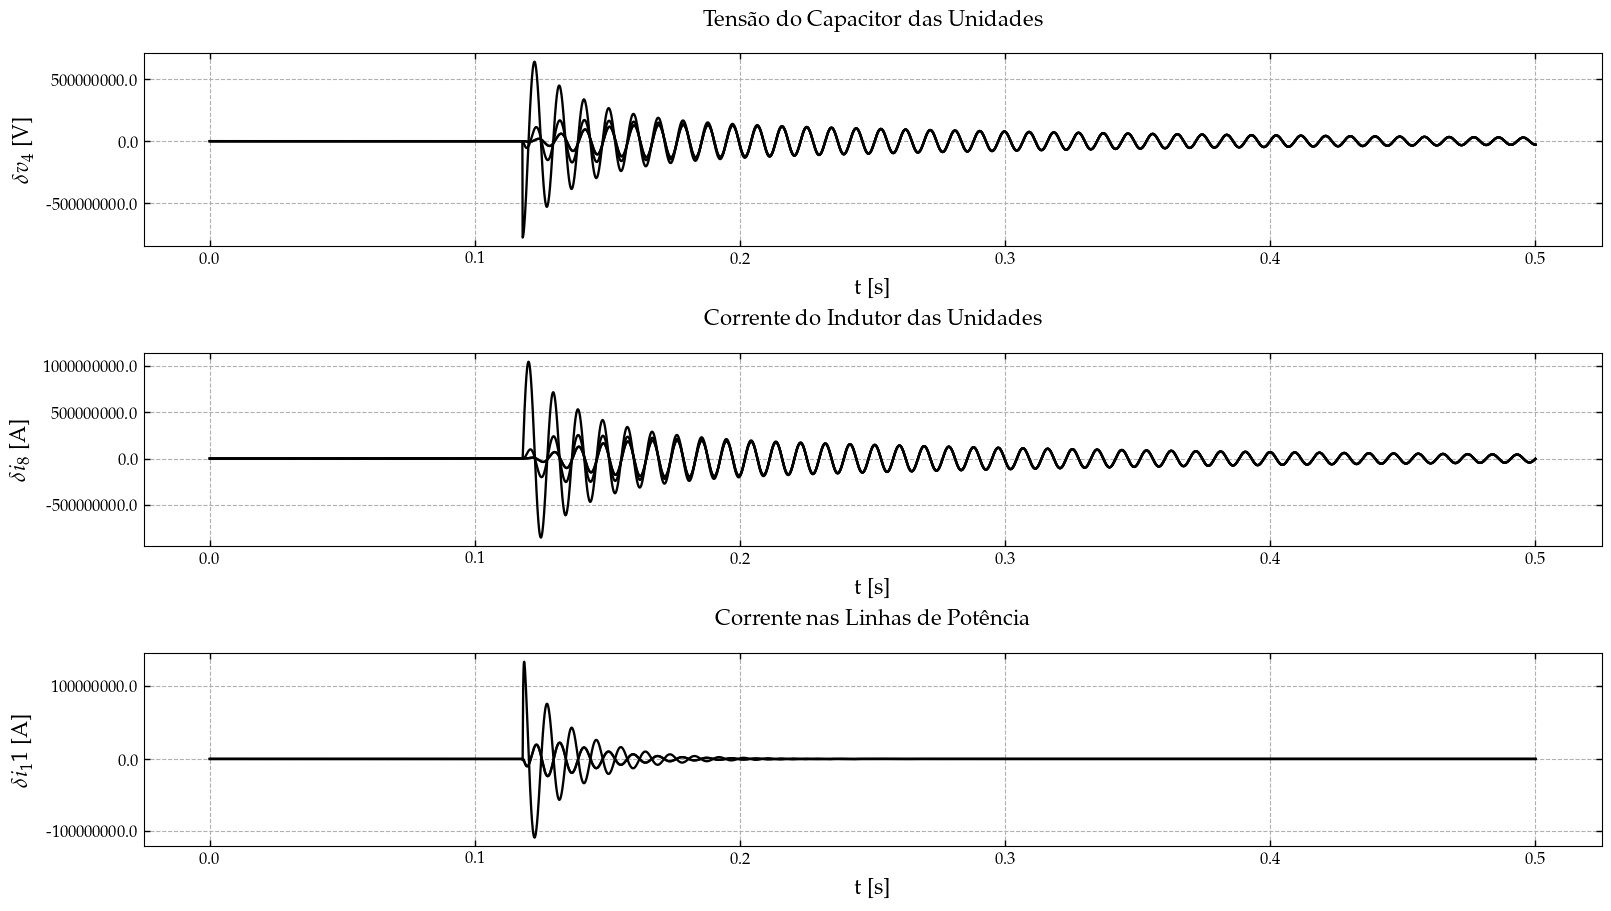

In [10]:
fig = plt.figure(figsize=(16, 9), layout='constrained')

mosaic = [['δv'], ['δit'], ['δi']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(axs[mosaic[0][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta v_{i+1}$ [V]',
           f'Tensão do Capacitor das Unidades',)
for i in range(dgs_amount, 2 * dgs_amount):
  gph.plot(axs[mosaic[1][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente do Indutor das Unidades',)
for i in range(2 * dgs_amount, 2 * dgs_amount + lines):
  gph.plot(axs[mosaic[2][0]], timepts, [v[i] for v in outputs],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente nas Linhas de Potência',)
# plt.tight_layout()

In [11]:
def solve_problem(
    h: float,
    υ: float,
    λ: Optional[float] = None,
    θ1: Optional[float] = None,
    θ2: Optional[float] = None,
    σ_bar: Optional[float] = None,
    eps: float = 1e-6
):
  n_u = dgs_amount
  n_p = 2 * dgs_amount
  n_x = 2 * dgs_amount + lines

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  A = {}
  B = {}

  u_bar = []
  for i in range(n_u):
    u_bar += [min(1 - dg_params['d_o'][i], dg_params['d_o'][i])]

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(ρi, dg_params))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(ρi, dg_params))

  e = nm.get_e(5 * [n_x] + [1, n_u])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = cp.Variable((n_u, n_x), name=f'K')
  L1til = cp.Variable((n_u, n_x), name=f'L1')
  L2til = cp.Variable((n_u, n_x), name=f'L2')
  ℵ = cp.Variable((n_u, n_u), diag=True)
  constraints += [ℵ >> eps * np.eye(ℵ.shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  λ = cp.Parameter(value=λ, name='λ')
  β = cp.Variable(pos=True)
  θ1 = cp.Parameter(value=θ1, name='θ1')
  θ2 = cp.Parameter(value=θ2, name='θ2')
  σ_bar = cp.Parameter(value=σ_bar, name='σ_bar')

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Λ(i):
    Bscr = A[i] @ X @ e[1] + B[i] @ Ktil @ e[2] - \
        X @ e[4] + B[i] @ Ktil @ e[5] - B[i] @ ℵ @ e[7]

    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[7] + S4til @ e[5]))

    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[7] + Q4til @ e[5]))

    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                         Q3til @ e[7] + Q4til @ e[5]))

    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[7] + S4til @ e[5])) + \
        e[4].T @ Rtil @ e[4]

    Θ5 = e[7].T @ (ℵ @ e[7] - L1til @ e[2] - L2til @ e[5])

    Θtil = {}
    Θtil['0'] = -λ * e[6].T @ e[6] - (1 + σ_bar * θ2) * e[5].T @ Ξtil @ e[5] - \
        Θ1 - h * e[3].T @ Q1til @ e[3] + h * Θ3 + h * κ1.T @ Mtil @ κ1 + \
        h * e[4].T @ Rtil @ e[4] + θ2 * e[2].T @ Ξtil @ e[2] - \
        Θ5 + nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) + h * Θ4

    Θtil['h'] = -λ * e[6].T @ e[6] - (1 + σ_bar * θ2) * e[5].T @ Ξtil @ e[5] - \
        Θ1 - h * Θ2 - h * e[3].T @ Q1til @ e[3] - h * κ1.T @ Mtil @ κ1 - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr -
              κ2.T @ Ytil) + θ2 * e[2].T @ Ξtil @ e[2]

    Γ1 = Θtil['0']

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal

    Γ2 = cp.bmat([[Γ2_11, Γ2_12],
                  [Γ2_21, Γ2_22]])

    return Γ1, Γ2

  # binary_pairs = nm.binary_pairs(n_p)

  # for pairs in binary_pairs:
  #   LMI_SUM = {}
  #   LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

  #   for pair in pairs:
  #     Λ = {}
  #     Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
  #     LMI_SUM['0'] += Λ['0']
  #     LMI_SUM['h'] += Λ['h']

  #   constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
  #   constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for i in Bnp:
    Λ1, Λ2 = get_Λ(i)
    constraints += [Λ1 << -eps * np.eye(Λ1.shape[0])]
    constraints += [Λ2 << -eps * np.eye(Λ2.shape[0])]

  for ell in range(n_u):
    # for j in Bnp:
    LMISAT11 = Ptil - Ξtil
    LMISAT12 = np.zeros((n_x, n_x))
    LMISAT13 = np.zeros((n_x, 1))
    LMISAT14 = (Ktil[ell:ell+1] - L1til[ell:ell+1]).T

    LMISAT21 = LMISAT12.T
    LMISAT22 = (1.0 / σ_bar) * Ξtil
    LMISAT23 = np.zeros((n_x, 1))
    LMISAT24 = (Ktil[ell:ell+1] - L2til[ell:ell+1]).T

    LMISAT31 = LMISAT13.T
    LMISAT32 = LMISAT23.T
    LMISAT33 = (1. - (1. / (σ_bar * θ1))) * np.eye(1)
    LMISAT34 = np.zeros((1, 1))

    LMISAT41 = LMISAT14.T
    LMISAT42 = LMISAT24.T
    LMISAT43 = LMISAT34.T
    LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)

    LMISAT = cp.bmat(
        [[LMISAT11, LMISAT12, LMISAT13, LMISAT14],
         [LMISAT21, LMISAT22, LMISAT23, LMISAT24],
         [LMISAT31, LMISAT32, LMISAT33, LMISAT34],
         [LMISAT41, LMISAT42, LMISAT43, LMISAT44]])

    constraints += [LMISAT >> 0]

  aq = nm.get_vertices(x_bounds)

  print(len(aq))

  for i in range(len(aq)):
    LMI_D11 = Ptil
    LMI_D12 = X.T @ aq[i]
    LMI_D21 = LMI_D12.T
    LMI_D22 = np.eye(1)

    LMI_D = cp.bmat([[LMI_D11, LMI_D12],
                     [LMI_D21, LMI_D22]])

    constraints += [LMI_D >> 0]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  constraints += [LMID0 >> 0]

  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv

    error = False

    if error == False:
      K = Ktil.value @ Xinv
      L1 = L1til.value @ Xinv
      L2 = L2til.value @ Xinv

      etm_results = {'Ξ': Ξ}
      design_results = {
          'optimal_value': prob.value,
          'etm': etm_results,
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': [P, S2],
          'bounds': [β.value]
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [ ]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
θ1, Θ2, λ = None, None, None
σ_bar = 10

# Parâmetros e resolução do problema
h, υ, θ2, λ = 1e-4, 1e-4, 1e2, 1e1
θ1 = (1. / λ) * (np.exp(λ * h) - 1) + 0.1
prob_res = solve_problem(h=h, υ=υ, λ=λ, θ1=θ1, θ2=θ2, σ_bar=σ_bar, eps=1e-5)

if prob_res is not None:
  Ξ = prob_res['etm']['Ξ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']
  β = prob_res['bounds']

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  display(Math(rf'K = {tex.mat2tex(K)}'))
  display(Math(rf'L1 = {tex.mat2tex(L1)}'))
else:
  print('Problema não é factível!')

22
Problema não é factível!


In [127]:
def closedloop_simulation(x0, η0, σ0, T_s):
  # Conversão inicial para float32
  x0 = np.array(x0, dtype=np.float32)
  η0 = np.array(η0, dtype=np.float32)
  σ0 = np.array(σ0, dtype=np.float32)
  T_s = np.float32(T_s)

  print("x0.T @ P @ x0", (x0.T @ P @ x0).item())

  if (x0.T @ P @ x0).item() > 1.1:
    raise ValueError(
        "O estado inicial x0 não pertence à região de estados iniciais estimada. "
        "A simulação será interrompida pois os resultados não são garantidos."
    )

  N = len(timepts)
  nx = x0.shape[0]

  # Pré-alocação dos vetores principais
  x = np.zeros((nx, N + 1, 1), dtype=np.float32)
  η = np.zeros((N + 1, 1), dtype=np.float32)
  σ = np.zeros((N + 1, 1), dtype=np.float32)

  x[:, 0, :] = x0
  η[0, :] = η0
  σ[0, :] = σ0

  y = []
  uc = []

  x_hat = x0.copy()
  xτ = x0.copy()

  next_time_sampling = np.float32(h)
  event_times = [np.float32(0.0)]

  # --- Funções internas ---
  def triggering_condition(_σ, _xτ, _ε, _η):
    Γ = _σ * (_xτ.T @ Ξ @ _xτ) - (_ε.T @ Ξ @ _ε)
    return (_η + θ1 * Γ) < np.float32(0)

  def sigma_dynamics(t, _σ, _η, params):
    _ε = x_hat - xτ
    σ_dot = (θ2 / _σ) * (((1.0 / _σ) - σ_bar) * (_ε.T @ Ξ @ _ε) -
                         (1.0 / (θ1 * _σ)) * _η) - (xτ.T @ Ξ @ xτ)
    return np.float32(σ_dot)

  def etm_dynamics(t, _η, _σ, params):
    ε = x_hat - xτ
    Γ = _σ * (xτ.T @ Ξ @ xτ) - (ε.T @ Ξ @ ε)
    η_dot = -λ * _η + Γ[0][0]
    return np.float32(η_dot)

  def control_signal():
    uc_k = np.float32(K @ x_hat)
    return np.array([sgn.sat(uc_k[i, 0], u_bar[i]) for i in range(len(uc_k))], dtype=np.float32)

  # --- Laço principal ---
  for k, t in enumerate(timepts):
    t = np.float32(t)

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += np.float32(h)
      xτ = x[:, k, :].astype(np.float32)
      ε = (x_hat - xτ).astype(np.float32)
      new_event = triggering_condition(σ[k, :], xτ, ε, η[k, :])
      if new_event:
        x_hat = xτ
        event_times.append(float(t))

    x_k = x[:, k, :].flatten().astype(np.float32)

    # Cálculo do sinal de controle
    u_sat = control_signal()

    # Parâmetros variantes
    ρ1 = np.array([1.0 / (vo[i] + x_k[i])
                  for i in range(dgs_amount)], dtype=np.float32)
    ρ2 = np.array([v[k] for v in Pl], dtype=np.float32)
    inputs = np.hstack((u_sat, ρ1, ρ2)).astype(np.float32)

    # Saída da planta
    y.append(plant_output(t, x[:, k, :].astype(
        np.float32), inputs, dg_params))
    uc.append(u_sat)

    # Integração numérica
    if k < N:
      x[:, k + 1, :] = nm.rk5_step(
          plant_dynamics, t, x[:, k, :].astype(
              np.float32), inputs, T_s, dg_params
      ).astype(np.float32)

      σ_next = nm.rk5_step(
          sigma_dynamics, t, σ[k, :], η[k, :], T_s, None).astype(np.float32)
      σ[k + 1, :] = np.maximum(σ_next, np.float32(1e-6))
      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :],
                                σ[k, :], T_s, None).astype(np.float32)

  return y, uc, σ[:N], η[:N], event_times

In [128]:
import numpy as np


def sample_ellipsoid_boundary(P, n_points=1000, seed=None):
  """
  Gera pontos na fronteira da elipsoide x.T P x = 1.
  P deve ser simétrica definida positiva (SPD).

  Parâmetros
  ----------
  P : ndarray (n, n)
      Matriz simétrica definida positiva.
  n_points : int
      Número de pontos a gerar.
  seed : int ou None
      Semente para o gerador aleatório. Se None, uma nova seed aleatória é criada.

  Retorna
  -------
  x_boundary : ndarray (n, n_points)
      Pontos na fronteira da elipsoide.
  seed : int
      Seed usada na geração (útil para reprodutibilidade).
  """
  n = P.shape[0]

  # define a seed
  if seed is None:
    seed = np.random.randint(0, 2**16 - 1)
  rng = np.random.default_rng(seed)

  # decomposição de Cholesky
  L = np.linalg.cholesky(P)

  # amostragem na esfera unitária
  x = rng.standard_normal((n, n_points))
  x /= np.linalg.norm(x, axis=0, keepdims=True)

  # transformação para a elipsoide
  x_boundary = np.linalg.solve(L.T, x)

  return x_boundary, seed


x0_list, seed_used = sample_ellipsoid_boundary(P, n_points=20, seed=5308)

print("Seed usada:", seed_used)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# Funções auxiliares
# -----------------------------


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'sigma': [np.array(sigma_k) for sigma_k in obj['sigma']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }

# -----------------------------
# Função de simulação
# -----------------------------


def get_trajectories(i):
  i = 19
  idx = i % x0_list.shape[1]
  x0 = x0_list[:, [idx]]
  η0 = np.array([[0.]])
  σ0 = 0.75

  # closedloop_simulation precisa estar definido globalmente
  y, uc, σ, η, event_times = closedloop_simulation(
      x0, η0, σ0, T_s=simulation_step
  )
  inter_event_times = np.diff(event_times).tolist()

  return {
      'trajectories': y,
      'sigma': σ,
      'eta': η,
      'control-signal': uc,
      'inter-event-times': inter_event_times
  }


# -----------------------------
# Configurações
# -----------------------------
experiment_name = "Results/Notebook-05/ClosedLoop_Results.json"
force_simulation = True
simulations_amount = 1

results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'sigma': [],
    'eta': [],
}

# -----------------------------
# Carregar ou simular
# -----------------------------
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  print("Executando simulações...")

  # ThreadPoolExecutor funciona de forma segura em notebooks
  with ThreadPoolExecutor() as executor:
    results = list(executor.map(
        get_trajectories, range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['sigma'].append(res['sigma'])
    results_clsim['eta'].append(res['eta'])

  # Salvar resultados
  results_serializable = convert_to_serializable(results_clsim)
  os.makedirs(os.path.dirname(experiment_name), exist_ok=True)
  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Executando simulações...
x0.T @ P @ x0 1.000000016044874
Simulações concluídas. Resultados salvos em Results/Notebook-05/ClosedLoop_Results.json.


Estado Inicial:  [ -9.428096    -1.4853818   -3.447982     7.8341413  -19.486006
   2.9730647  -26.533518    -3.8008022    1.6240155    0.38891935
  -2.4919484 ]
Número de Eventos Acionados:  121
Menor IET Obtido:  0.0003000000142492354
Máximo IET Obtido:  0.05830000340938568
Média do Intervalos de Tempo entre Eventos:  0.004121487544587821


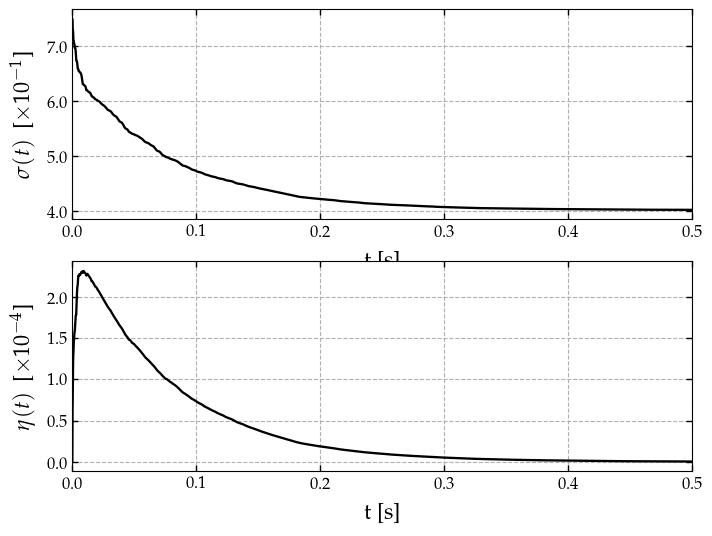

In [ ]:
%matplotlib inline

cfg = {
    'style': { 'color': 'black', },
    'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
              'x_label_fontsize': 16,
              'y_label_fontsize': 16,
              'tick_fontsize': 18,},
    'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
  }

simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
_σ = results_clsim['sigma'][simulation_index]
η = results_clsim['eta'][simulation_index]
event_times = np.cumsum(inter_event_times)

mosaic = [['σ'], ['η']]    
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': timepts[-1]}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )

σ_f, σ_ul, σ_dp = nm.format_magnitudes(
    _σ, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['σ'], t_formatted, σ_f,
    xlabel='t [s]', ylabel='$\\sigma(t)\\,$' + σ_ul,
    title='',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': σ_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })

n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_formatted, n_f,
    xlabel='t [s]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': n_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })

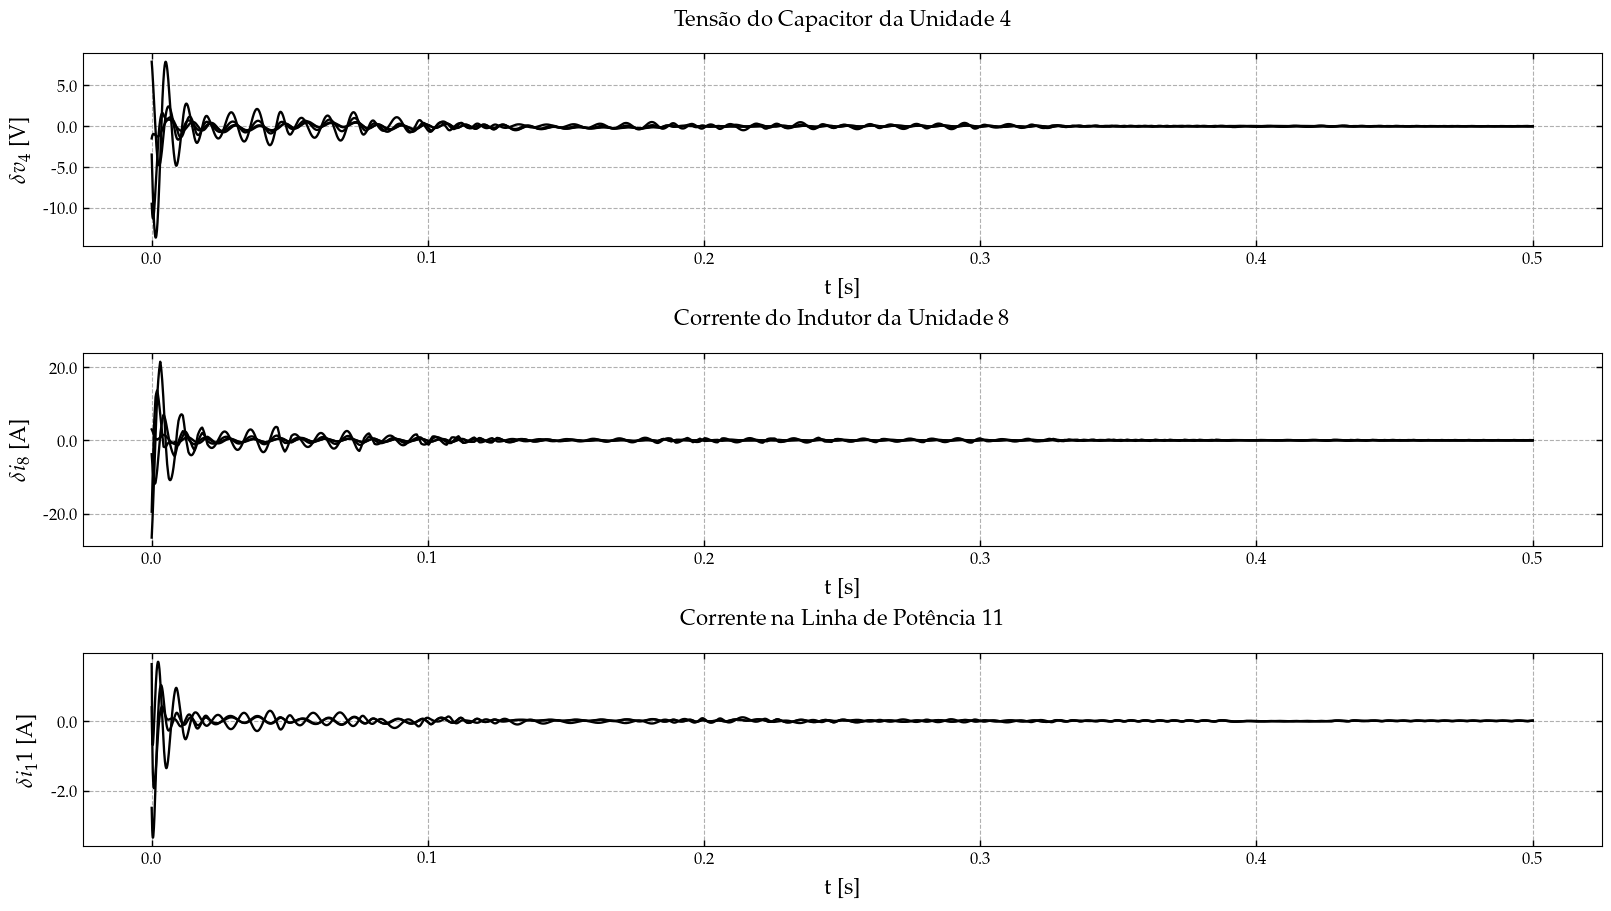

In [ ]:
fig = plt.figure(figsize=(16, 9), layout='constrained')

mosaic = [['δv'], ['δit'], ['δi']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(axs[mosaic[0][0]], timepts, [v[i] for v in y],
           't [s]', f'$\\delta v_{i+1}$ [V]',
           f'Tensão do Capacitor da Unidade {i+1}',)
for i in range(dgs_amount, 2 * dgs_amount):
  gph.plot(axs[mosaic[1][0]], timepts, [v[i] for v in y],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente do Indutor da Unidade {i+1}',)
for i in range(2 * dgs_amount, 2 * dgs_amount + lines):
  gph.plot(axs[mosaic[2][0]], timepts, [v[i] for v in y],
           't [s]', f'$\\delta i_{i+1}$ [A]',
           f'Corrente na Linha de Potência {i+1}',)
# plt.tight_layout()

C:\Users\andel\AppData\Local\Temp\ipykernel_14304\1296982879.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.)


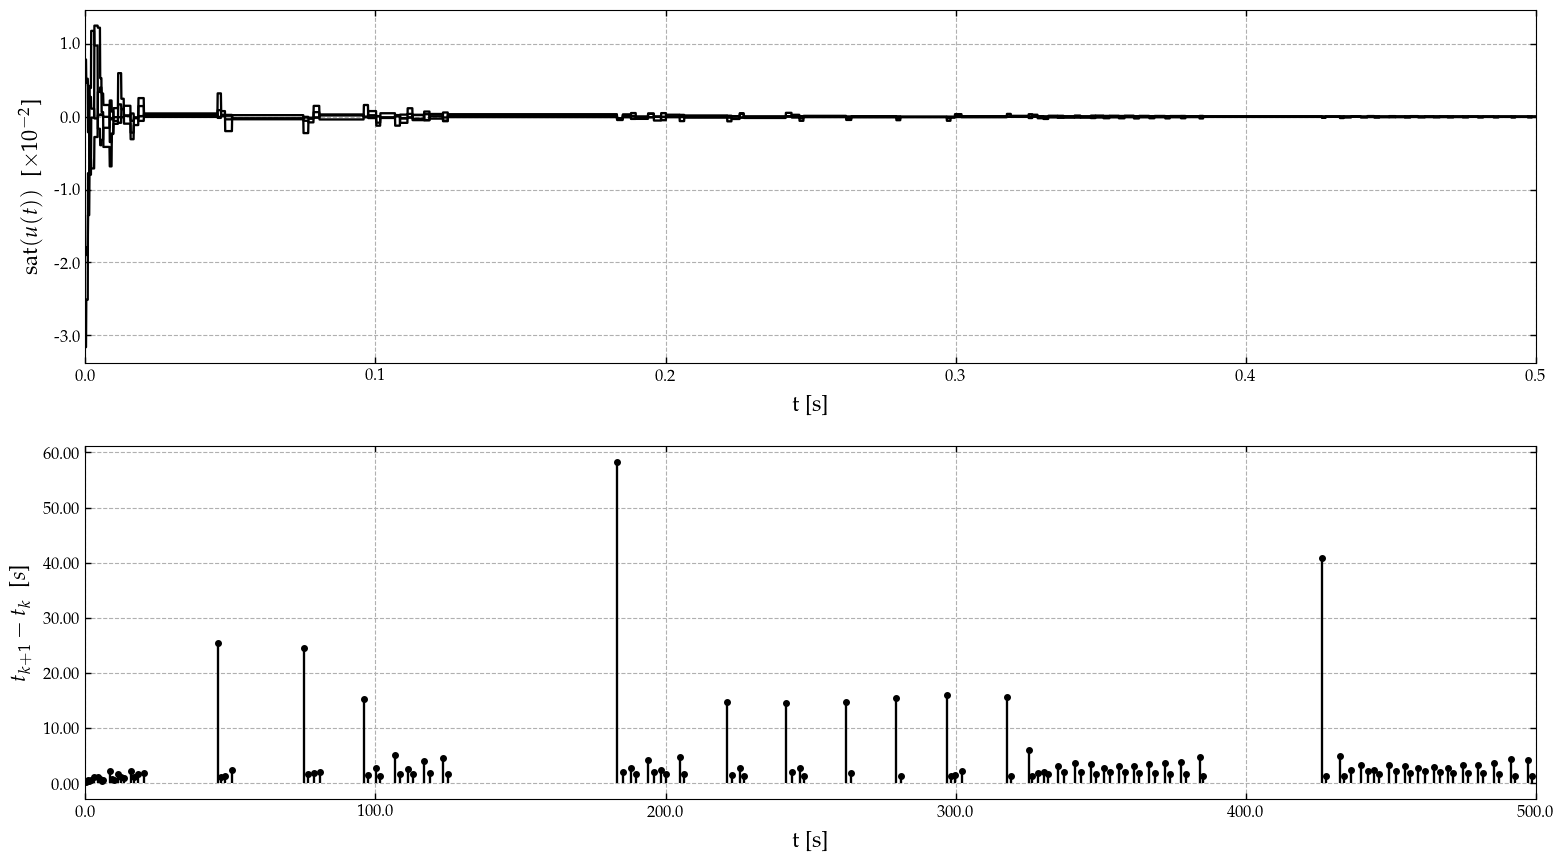

In [ ]:
fig = plt.figure(figsize=(16, 9), layout='constrained')

mosaic = [['sat'], ['iet']]
axs = fig.subplot_mosaic(mosaic)

for i in range(dgs_amount):
  gph.plot(
      axs['sat'], t_formatted,
      [float(v[i]) * 1e2 for v in uc],
      xlabel='t [s]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-2}$]',
      # title='Sinal de Controle Saturado (sat($u(t)$))',
      plot_cfg={**cfg,
                'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                         'y_digits': 1},
                'limits': {**cfg['limits'], **axis_limits},
                'legend': {'fontsize': 16}
                })

# Plot dos IETs
if len(inter_event_times) > 0:
  stem_cfg = cfg.copy()
  stem_cfg['axis']['y_digits'] = 0

  gph.stem(
      axs['iet'], [et * 1e3 for et in event_times],
      [et * 1e3 for et in inter_event_times],
      xlabel='t [s]', ylabel='$t_{k+1} - t_k\\;$ [$s$]',
      # title='Intervalos entre Eventos',
      stem_cfg={**cfg,
                'axis': {**cfg['axis'], 'x_digits': t_decimal_places,
                         'y_digits': 2},
                'limits': {'x_min': 0., 'x_max': timepts[-1] * 1e3},
                })


else:
  axs['iet'].text(0.5, 0.5, 'No triggered events',
                  ha='center', va='center', fontsize=14,
                  transform=axs['iet'].transAxes)
  axs['iet'].set_title('Inter-event Times')
  axs['iet'].set_xlabel('t [s]')
  axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
  axs['iet'].set_xlim([0, simulation_time])
  axs['iet'].set_ylim([0, 1])  # valor simbólico
  axs['iet'].grid(False)

plt.tight_layout(pad=2.)